In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install xgboost

In [3]:
!pip install lightgbm

In [4]:
!pip install catboost

In [5]:
# path
train_path=r"C:\Users\MMM\Downloads\solana-skill-sprint-memcoin-graduation\train.csv"
test_path=r"C:\Users\MMM\Downloads\solana-skill-sprint-memcoin-graduation\test_unlabeled.csv"

In [8]:
# Load train.csv

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Check the data
print(train_df.head())
print(test_df.head())

   Unnamed: 0                                          mint   slot_min  \
0           1  BmTDA5HqcemLkEgpyK25sDhbvk652CTXjdWEa8fLpump  317876496   
1           3  4FJwryCAMMePNeWw9LTBXXfXABdkKcAxkTT6h9pdpump  317876500   
2           4  DeXchZLMzFm9nfvkfTKiXvBWWEpGMF6VDzvbMB6mpump  317876500   
3           5  6Mx4fnEPWpRLKtxY8VzVXo3CWwu2dvGp9BSJMWfVpump  317876500   
4           6  4rbGH5peYV3FvCfncfsfwtBNwpjiG36nZtvxoPZ9pump  317876500   

   slot_graduated  has_graduated  is_valid  
0             NaN          False      True  
1             NaN          False      True  
2             NaN          False      True  
3             NaN          False      True  
4             NaN          False      True  
   Unnamed: 0                                          mint   slot_min  \
0           0  9Wt3N7etKMX9cioTdEJ5S4b8A9nK3M66n9RFVgBGpump  320921219   
1           1  9q5y2X2P8ZEKTjyXBVcS5q2EZM7HbNV8DURY2qnvqi2f  320921220   
2           2  HL2di8dcQ7eYDmkcFoZ4zJyHX5SbRZXAJxTegL3JPfx2  32

In [9]:
train_df.info()
train_df.describe()
train_df['has_graduated'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639557 entries, 0 to 639556
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      639557 non-null  int64  
 1   mint            639557 non-null  object 
 2   slot_min        639557 non-null  int64  
 3   slot_graduated  7404 non-null    float64
 4   has_graduated   639557 non-null  bool   
 5   is_valid        639557 non-null  bool   
dtypes: bool(2), float64(1), int64(2), object(1)
memory usage: 20.7+ MB


False    0.988423
True     0.011577
Name: has_graduated, dtype: float64

<AxesSubplot:title={'center':'Target Balance'}, xlabel='has_graduated', ylabel='count'>

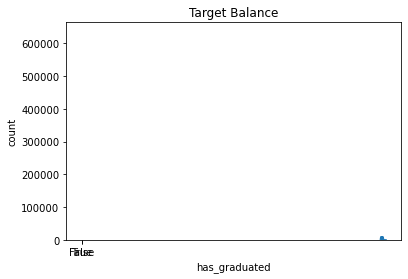

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train_df, x='has_graduated')
plt.title("Target Balance")

sns.histplot(train_df['slot_min'], kde=True)
sns.histplot(train_df['slot_graduated'].dropna(), kde=True)


In [11]:
train_df['slot_diff'] = train_df['slot_graduated'] - train_df['slot_min']
train_df['slot_diff'] = train_df['slot_diff'].fillna(-1)

test_df['slot_diff'] = -1  # Since test has no slot_graduated


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Combine train and test mint for consistent label encoding
all_mints = pd.concat([train_df['mint'], test_df['mint']])
le.fit(all_mints)

# Now transform safely
train_df['mint_encoded'] = le.transform(train_df['mint'])
test_df['mint_encoded'] = le.transform(test_df['mint'])


In [13]:
features = ['slot_min', 'slot_diff', 'mint_encoded']
X = train_df[features]
y = train_df['has_graduated'].astype(int)
X_test = test_df[features]


In [14]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    #'SVC': SVC(probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

# Evaluate
for name, model in models.items():
    auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc').mean()
    print(f"{name} - AUC: {auc:.4f}")


RandomForest - AUC: 1.0000
GradientBoosting - AUC: 1.0000
LogisticRegression - AUC: 1.0000
XGBoost - AUC: 0.9984
[LightGBM] [Info] Number of positive: 5923, number of negative: 505722
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 511645, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011576 -> initscore=-4.447144
[LightGBM] [Info] Start training from score -4.447144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

In [15]:
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        ('lgb', LGBMClassifier()),
        ('cat', CatBoostClassifier(verbose=0))
    ],
    voting='soft'
)

voting_clf.fit(X, y)
preds = voting_clf.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 7404, number of negative: 632153
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 639557, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.011577 -> initscore=-4.447111
[LightGBM] [Info] Start training from score -4.447111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [16]:
submission = pd.DataFrame({
    'mint': test_df['mint'],
    'has_graduated': preds
})
submission.to_csv("submission.csv", index=False)


In [17]:
submission

,mint,has_graduated
0,9Wt3N7etKMX9cioTdEJ5S4b8A9nK3M66n9RFVgBGpump,0.000026
1,9q5y2X2P8ZEKTjyXBVcS5q2EZM7HbNV8DURY2qnvqi2f,0.000026
2,HL2di8dcQ7eYDmkcFoZ4zJyHX5SbRZXAJxTegL3JPfx2,0.000015
3,7iAFj9Pc5QH9jbGmHwYe8T6yzNVbjhL13PNJXVTspump,0.000016
4,F7U1Rdgz2KFpneKpAnYytWF2jggnsrLScfi2A668pump,0.000028
...,...,...
478827,BRDCfyWZaZURhCwDyst2UufM1yJ7r2hiBQurp323pump,0.000261
478828,Dt5gdJqfAnn6EiimukYwpEkg5VnT7s4CGuPjM7ahpump,0.000014
478829,2tGi3egEvr7gH5VD3DC8BWrWB4sem3XetcRzdh6gpump,0.000026
478830,6Lyy15Hondyj4XTWf6SzviioAuxoYs1UiMEvL74Gpump,0.000010
